In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mno
import seaborn as sns
import time

In [4]:
df= pd.read_json("Software.json.gz",lines=True,chunksize=10000)

In [5]:
data = pd.DataFrame()
for chunk in df:
    data = data.append(chunk)

In [6]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN
1,4,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN
2,1,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN
3,3,True,"02 17, 2014",APRDVZ6QBIQXT,0077613252,{'Format:': ' Loose Leaf'},Lucy,This book was missing pages!!! Important pages...,missing pages!!,1392595200,3,NaN
4,5,False,"10 14, 2013",A2JZTTBSLS1QXV,0077775473,NaN,Albert V.,I have used LearnSmart and can officially say ...,Best study product out there!,1381708800,NaN,NaN


|Variables|Description|
|---|---|
|reviewerID | ID of the reviewer, e.g. A2SUAM1J3GNN3B |
|asin | ID of the product, e.g. 0000013714 |
|reviewerName | name of the reviewer |
|vote | helpful votes of the review |
|style | a disctionary of the product metadata, e.g., "Format" is "Hardcover" |
|reviewText | text of the review |
|overall | rating of the product |
|summary | summary of the review |
|unixReviewTime | time of the review (unix time) |
|reviewTime | time of the review (raw) |
|image | images that users post after they have received the product |

In [5]:
data.describe()

,overall,unixReviewTime
count,459436.000000,4.594360e+05
mean,3.570175,1.369691e+09
std,1.626662,1.150168e+08
min,1.000000,9.127296e+08
25%,2.000000,1.322179e+09
50%,4.000000,1.405814e+09
75%,5.000000,1.448237e+09
max,5.000000,1.538438e+09


In [7]:
train_data = data.drop(columns= ['verified', 'reviewTime', 'style', 'reviewText', 'summary', 
                                 'unixReviewTime', 'vote', 'image', 'reviewerName'])

In [8]:
train_data.head()

,overall,reviewerID,asin
0,4,A240ORQ2LF9LUI,0077613252
1,4,A1YCCU0YRLS0FE,0077613252
2,1,A1BJHRQDYVAY2J,0077613252
3,3,APRDVZ6QBIQXT,0077613252
4,5,A2JZTTBSLS1QXV,0077775473


In [9]:
col_list = train_data.columns
col_list

Index(['overall', 'reviewerID', 'asin'], dtype='object')

In [10]:
for c in col_list:
    if c != 'overall':
        train_data[c] = train_data[c].astype('category')
        train_data[c] = train_data[c].cat.codes

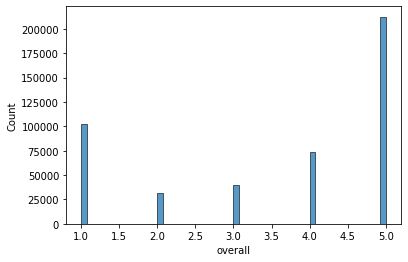

In [10]:
sns.histplot(data['overall'], kde= False)

# Collobrative Filtering

## Weighted Item Mean

In [11]:
from sklearn.model_selection import train_test_split
X = train_data.drop(columns='overall')
y = train_data['overall']

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(344577, 2)

In [12]:
X_train.head()

,reviewerID,asin
18906,249923,5586
198831,308295,17025
15055,178900,4794
102592,209503,13487
154836,307470,15600


In [13]:
from sklearn.metrics import mean_squared_error
y

0         4
1         4
2         1
3         3
4         5
         ..
459431    2
459432    1
459433    5
459434    5
459435    5
Name: overall, Length: 459436, dtype: int64

In [14]:
def baseline_score():
    id_pairs = zip(X_test['reviewerID'], X_test['asin'])
    y_pred = np.array([5 for (reviewer, item) in id_pairs])
    y_true = np.array(y_test)
    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [15]:
baseline_score()

2.1605780259886984

In [13]:
rows = train_data.reviewerID.nunique()
cols = train_data.asin.nunique()
[rows, cols]

[375147, 21663]

In [14]:
from scipy import sparse
spr = sparse.lil_matrix((rows, cols))
y_train.head()


18906     5
198831    5
15055     3
102592    5
154836    1
Name: overall, dtype: int64

In [20]:
y_train[18906]

5

In [21]:
x_ind = X_train.index.values.tolist()
for i in range(train_data.shape[0]):
    if i in x_ind:
        spr[X_train['reviewerID'][i], X_train['asin'][i]]= y_train[i]

In [19]:
# mean
def cf_user_mean(reviewerID, itemID):
    
    return spr.mean(axis=0)[0, itemID]
   

In [24]:
def score_itemmean():
    means = spr.sum(axis=0).A1/spr.getnnz(axis=0)
    id_pairs = zip(X_test['reviewerID'], X_test['asin'])
    y_pred = np.array([means[item] for (reviewer, item) in id_pairs])
    y_true = np.array(y_test)
    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [25]:
score_itemmean()

1.4624379856637977

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor
randomf = RandomForestRegressor(n_estimators=200)
randomf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [36]:
from sklearn.metrics import mean_absolute_error

In [37]:
print('Mean Absolute Error for Training Set:', mean_absolute_error(y_train, randomf.predict(X_train)))
print('Mean Absolute Error for Test Set:', mean_absolute_error(y_test, randomf.predict(X_test)))

Mean Absolute Error for Training Set: 0.5045102371202677
Mean Absolute Error for Test Set: 1.371925887081428


The above result was produced after the model was run for approximately 1 hour

## Linear Regression

In [29]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
print('Mean Absolute Error for Training Set:', mean_absolute_error(y_train, model.predict(X_train)))
print('Mean Absolute Error for Test Set:', mean_absolute_error(y_test, model.predict(X_test)))

Mean Absolute Error for Training Set: 1.4557151348451016
Mean Absolute Error for Test Set: 1.4538083680611693


## SVM linear regressor	

In [31]:
from sklearn.svm import LinearSVR
svm = LinearSVR(random_state=0, tol=1e-5)
svm.fit(X_train, y_train)

C:\Users\omarf\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=0, tol=1e-05, verbose=0)

In [32]:
print('Mean Absolute Error for Training Set:', mean_absolute_error(y_train, svm.predict(X_train)))
print('Mean Absolute Error for Test Set:', mean_absolute_error(y_test, svm.predict(X_test)))

Mean Absolute Error for Training Set: 2.08884799675212
Mean Absolute Error for Test Set: 2.0823428668172688


## KNNs Regressor

In [33]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
print('Mean Absolute Error for Training Set:', mean_absolute_error(y_train, neigh.predict(X_train)))
print('Mean Absolute Error for Test Set:', mean_absolute_error(y_test, neigh.predict(X_test)))

Mean Absolute Error for Training Set: 0.8029642140943823
Mean Absolute Error for Test Set: 1.5258577908566155


## Decision Tree Regressor	

In [34]:
from sklearn.tree import DecisionTreeRegressor
Tree = DecisionTreeRegressor(random_state=0)
Tree.fit(X_train, y_train)
print('Mean Absolute Error for Training Set:', mean_absolute_error(y_train, Tree.predict(X_train)))
print('Mean Absolute Error for Test Set:', mean_absolute_error(y_test, Tree.predict(X_test)))

Mean Absolute Error for Training Set: 0.00012188857642849059
Mean Absolute Error for Test Set: 1.496147450352171


|Model|Test score|Efficency|
|---|---|---|
|Mean based CF|1.4624379856637977|good|
|Random Forest|1.371925887081428|bad|
|Linear Regression|1.4538083680611693|good|
|SVM linear regressor|2.0823428668172688|NA|
|KNNs Regressor|1.5258577908566155|good|
|Decision Tree Regressor|1.496147450352171|good|